# Modelos de Clasificación para Mantenimiento Predictivo

Este notebook cubre:
- Análisis Exploratorio de Datos (EDA) de las clases
- Modelos de clasificación (Árbol de Decisión, Random Forest, SVM)
- Visualización de árboles de decisión
- Predicción de fallas usando datos de `faliure_probability_base`

## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Carga de Datos desde MySQL

In [2]:
import mysql.connector
from mysql.connector import Error

# Configuración de la base de datos
DB_CONFIG = {
    'host': '127.0.0.1',
    'database': 'palantir_maintenance',
    'user': 'root',
    'password': 'admin',
    'port': 3306
}

def cargar_datos():
    """Cargar datos de la tabla faliure_probability_base"""
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        if connection.is_connected():
            query = """
            SELECT * 
            FROM faliure_probability_base
            """
            df = pd.read_sql(query, connection)
            connection.close()
            return df
    except Error as e:
        print(f"Error al conectar: {e}")
        return None

# Cargar datos
df = cargar_datos()
if df is not None:
    print(f"Datos cargados: {df.shape}")
    print(f"\nColumnas: {list(df.columns)}")
    print(f"\nPrimeras filas:")
    print(df.head())
else:
    print("No se pudieron cargar los datos")

Datos cargados: (8, 42)

Columnas: ['base_id', 'asset_id', 'extraction_date', 'asset_age_days', 'asset_status', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value', 'sensor_avg_warning_value', 'sensor_avg_critical_value', 'sensor_max_value', 'sensor_min_value', 'sensor_std_value', 'failure_count_365d', 'failure_critical_count', 'failure_high_count', 'failure_medium_count', 'failure_low_count', 'failure_avg_downtime', 'failure_total_downtime', 'failure_unresolved_count', 'days_since_last_failure', 'task_total_365d', 'task_completed_count', 'task_in_progress_count', 'task_pending_count', 'task_avg_estimated_hours', 'task_avg_actual_hours', 'task_total_hours', 'days_since_last_task', 'order_total_365d', 'order_preventive_count', 'order_corrective_count', 'order_emergency_count', 'order_completed_count', 'order_avg_estimated_cost', 'order_avg_actual_cost', 'order_total_actual_cost', 'days_since_last_order', 'created_at', 'updated_

## 3. Preparación de Datos y Creación de Variable Objetivo

In [3]:
if df is not None and len(df) > 0:
    # Crear variable objetivo basada en características de falla
    # Usaremos failure_count_365d para crear clases de riesgo
    def crear_clase_riesgo(row):
        """Crear clase de riesgo basada en múltiples factores"""
        failure_count = row.get('failure_count_365d', 0) or 0
        sensor_critical = row.get('sensor_critical_count_30d', 0) or 0
        
        # Clasificación: 0=Bajo, 1=Medio, 2=Alto, 3=Crítico
        if failure_count >= 5 or sensor_critical >= 10:
            return 3  # Crítico
        elif failure_count >= 3 or sensor_critical >= 5:
            return 2  # Alto
        elif failure_count >= 1 or sensor_critical >= 2:
            return 1  # Medio
        else:
            return 0  # Bajo
    
    # Aplicar función
    df['clase_riesgo'] = df.apply(crear_clase_riesgo, axis=1)
    
    # Seleccionar características para el modelo
    feature_columns = [
        'asset_age_days',
        'sensor_total_readings_30d',
        'sensor_warning_count_30d',
        'sensor_critical_count_30d',
        'sensor_avg_normal_value',
        'sensor_avg_warning_value',
        'sensor_max_value',
        'sensor_min_value',
        'failure_count_365d',
        'failure_critical_count',
        'failure_high_count',
        'failure_medium_count',
        'failure_avg_downtime',
        'days_since_last_failure',
        'task_total_365d',
        'task_completed_count',
        'days_since_last_task',
        'order_total_365d',
        'order_preventive_count',
        'order_corrective_count',
        'days_since_last_order'
    ]
    
    # Filtrar columnas que existen en el DataFrame
    available_features = [col for col in feature_columns if col in df.columns]
    
    # Preparar datos
    X = df[available_features].fillna(0)
    y = df['clase_riesgo']
    
    print(f"Características seleccionadas: {len(available_features)}")
    print(f"\nDistribución de clases:")
    print(y.value_counts().sort_index())
    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
else:
    print("No hay datos disponibles")

Características seleccionadas: 21

Distribución de clases:
clase_riesgo
1    8
Name: count, dtype: int64

Forma de X: (8, 21)
Forma de y: (8,)


## 4. Análisis Exploratorio de Datos (EDA) de las Clases

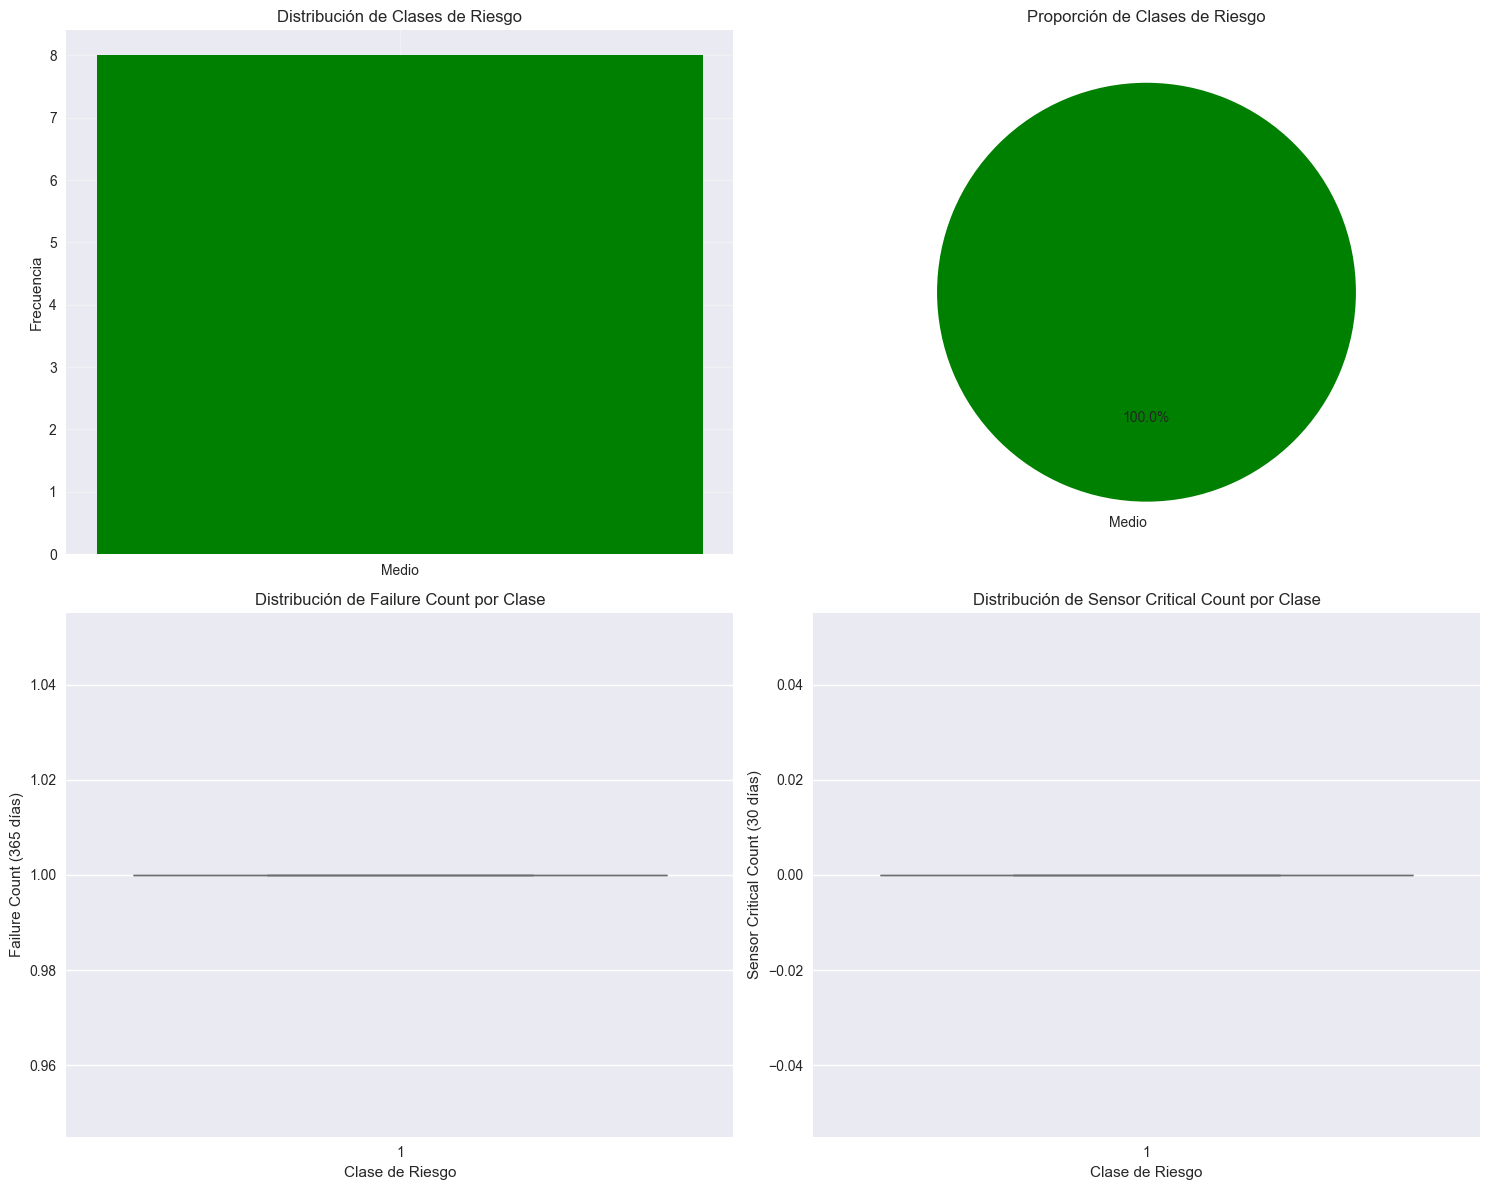


Estadísticas por clase:
              count  mean  std  min  25%  50%  75%  max
clase_riesgo                                           
1               8.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0


In [4]:
if df is not None and 'clase_riesgo' in df.columns:
    # Distribución de clases
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Distribución de clases
    clase_counts = df['clase_riesgo'].value_counts().sort_index()
    clase_labels = ['Bajo', 'Medio', 'Alto', 'Crítico']
    axes[0, 0].bar(range(len(clase_counts)), clase_counts.values, color=['green', 'yellow', 'orange', 'red'])
    axes[0, 0].set_xticks(range(len(clase_counts)))
    axes[0, 0].set_xticklabels([clase_labels[i] if i < len(clase_labels) else f'Clase {i}' for i in clase_counts.index])
    axes[0, 0].set_title('Distribución de Clases de Riesgo')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfico 2: Pie chart
    axes[0, 1].pie(clase_counts.values, labels=[clase_labels[i] if i < len(clase_labels) else f'Clase {i}' for i in clase_counts.index], 
                   autopct='%1.1f%%', startangle=90, colors=['green', 'yellow', 'orange', 'red'])
    axes[0, 1].set_title('Proporción de Clases de Riesgo')
    
    # Gráfico 3: Relación entre failure_count y clase
    if 'failure_count_365d' in df.columns:
        sns.boxplot(data=df, x='clase_riesgo', y='failure_count_365d', ax=axes[1, 0])
        axes[1, 0].set_title('Distribución de Failure Count por Clase')
        axes[1, 0].set_xlabel('Clase de Riesgo')
        axes[1, 0].set_ylabel('Failure Count (365 días)')
    
    # Gráfico 4: Relación entre sensor_critical_count y clase
    if 'sensor_critical_count_30d' in df.columns:
        sns.boxplot(data=df, x='clase_riesgo', y='sensor_critical_count_30d', ax=axes[1, 1])
        axes[1, 1].set_title('Distribución de Sensor Critical Count por Clase')
        axes[1, 1].set_xlabel('Clase de Riesgo')
        axes[1, 1].set_ylabel('Sensor Critical Count (30 días)')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas por clase
    print("\nEstadísticas por clase:")
    if 'failure_count_365d' in df.columns:
        print(df.groupby('clase_riesgo')['failure_count_365d'].describe())

## 5. División de Datos en Train y Test

In [5]:
if 'X' in locals() and 'y' in locals():
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Datos de entrenamiento: {X_train.shape}")
    print(f"Datos de prueba: {X_test.shape}")
    print(f"\nDistribución en entrenamiento:")
    print(y_train.value_counts().sort_index())
    print(f"\nDistribución en prueba:")
    print(y_test.value_counts().sort_index())
    
    # Estandarizar características (importante para algunos modelos)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\nDatos estandarizados correctamente")
else:
    print("No hay datos preparados")

Datos de entrenamiento: (6, 21)
Datos de prueba: (2, 21)

Distribución en entrenamiento:
clase_riesgo
1    6
Name: count, dtype: int64

Distribución en prueba:
clase_riesgo
1    2
Name: count, dtype: int64

Datos estandarizados correctamente


## 6. Modelo 1: Árbol de Decisión

In [6]:
if 'X_train' in locals():
    # Crear y entrenar árbol de decisión
    dt_model = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    
    dt_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_dt = dt_model.predict(X_test)
    
    # Métricas
    print("Árbol de Decisión - Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_dt, 
                                target_names=['Bajo', 'Medio', 'Alto', 'Crítico']))
    
    # Matriz de confusión
    cm_dt = confusion_matrix(y_test, y_pred_dt)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bajo', 'Medio', 'Alto', 'Crítico'],
                yticklabels=['Bajo', 'Medio', 'Alto', 'Crítico'])
    plt.title('Matriz de Confusión - Árbol de Decisión')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
    
    print("\nModelo entrenado correctamente")
else:
    print("No hay datos de entrenamiento")

Árbol de Decisión - Reporte de Clasificación:


ValueError: Number of classes, 1, does not match size of target_names, 4. Try specifying the labels parameter

## 7. Visualización del Árbol de Decisión

In [ ]:
if 'dt_model' in locals() and 'X_train' in locals():
    # Visualizar árbol completo (puede ser muy grande)
    plt.figure(figsize=(20, 12))
    plot_tree(dt_model, 
              feature_names=X_train.columns,
              class_names=['Bajo', 'Medio', 'Alto', 'Crítico'],
              filled=True,
              rounded=True,
              fontsize=10,
              max_depth=3)  # Limitar profundidad para visualización
    plt.title('Árbol de Decisión - Clasificación de Riesgo de Fallas', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': dt_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Características Más Importantes - Árbol de Decisión')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 características más importantes:")
    print(feature_importance.head(10))
else:
    print("No hay modelo entrenado")

## 8. Modelo 2: Random Forest

In [ ]:
if 'X_train' in locals():
    # Crear y entrenar Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_rf = rf_model.predict(X_test)
    
    # Métricas
    print("Random Forest - Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_rf, 
                                target_names=['Bajo', 'Medio', 'Alto', 'Crítico']))
    
    # Importancia de características
    rf_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=rf_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Características Más Importantes - Random Forest')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print("\nModelo Random Forest entrenado correctamente")
else:
    print("No hay datos de entrenamiento")

## 9. Modelo 3: Support Vector Machine (SVM)

In [ ]:
if 'X_train_scaled' in locals():
    # Crear y entrenar SVM (requiere datos estandarizados)
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
    
    svm_model.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred_svm = svm_model.predict(X_test_scaled)
    
    # Métricas
    print("SVM - Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_svm, 
                                target_names=['Bajo', 'Medio', 'Alto', 'Crítico']))
    
    print("\nModelo SVM entrenado correctamente")
else:
    print("No hay datos estandarizados")

## 10. Comparación de Modelos

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'y_pred_dt' in locals() and 'y_pred_rf' in locals() and 'y_pred_svm' in locals():
    # Calcular métricas para cada modelo
    modelos = {
        'Árbol de Decisión': y_pred_dt,
        'Random Forest': y_pred_rf,
        'SVM': y_pred_svm
    }
    
    resultados = []
    for nombre, predicciones in modelos.items():
        resultados.append({
            'Modelo': nombre,
            'Accuracy': accuracy_score(y_test, predicciones),
            'Precision': precision_score(y_test, predicciones, average='weighted'),
            'Recall': recall_score(y_test, predicciones, average='weighted'),
            'F1-Score': f1_score(y_test, predicciones, average='weighted')
        })
    
    df_resultados = pd.DataFrame(resultados)
    print("Comparación de Modelos:")
    print(df_resultados.round(4))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    df_resultados.set_index('Modelo').plot(kind='bar', ax=ax)
    plt.title('Comparación de Métricas entre Modelos')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Métricas')
    plt.tight_layout()
    plt.show()
else:
    print("No hay modelos entrenados para comparar")

## Resumen

En este notebook hemos aprendido:
1. ✅ Carga de datos desde MySQL
2. ✅ Creación de variable objetivo (clases de riesgo)
3. ✅ Análisis Exploratorio de Datos (EDA) de las clases
4. ✅ Entrenamiento de modelos de clasificación (Árbol de Decisión, Random Forest, SVM)
5. ✅ Visualización de árbol de decisión
6. ✅ Comparación de modelos

**Próximos pasos:** En el siguiente notebook aprenderemos sobre métricas de evaluación detalladas.